In [82]:
from pathlib import Path
import re
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

In [83]:
building_id = "5a0546857ecc773753327266"
floor_id = "B1"
trace_id = "5e15bf91f4c3420006d52341"

data_descriptions = {
    "TYPE_WAYPOINT" : {
        "x" : float,
        "y" : float,
    },
    "TYPE_ACCELEROMETER" : {
        "x" : float,
        "y" : float,
        "z" : float,
        "accuracy" : int,
    },
    "TYPE_MAGNETIC_FIELD" : {
        "x" : float,
        "y" : float,
        "z" : float,
        "accuracy" : int,
    },
    "TYPE_GYROSCOPE" : {
        "ang_speed_x" : float,
        "ang_speed_y" : float,
        "ang_speed_z" : float,
        "accuracy" : int,

    },
    "TYPE_ROTATION_VECTOR" : {
        "a" : float,
        "b" : float,
        "c" : float,
        "accuracy" : int,

    },
    "TYPE_MAGNETIC_FIELD_UNCALIBRATED" : {
        'x_uncalib' : float,   
        'y_uncalib' : float,   
        'z_uncalib' : float,   
        'x_bias' : float,  
        'y_bias' : float,  
        'z_bias' : float,
        "accuracy" : int,

    },
    "TYPE_GYROSCOPE_UNCALIBRATED" : {
        "ang_speed_x" : float,
        "ang_speed_y" : float,
        "ang_speed_z" : float,
        "drift_x" : float,
        "drift_y" : float,
        "drift_z" : float,
        "accuracy" : int,
    },
    "TYPE_ACCELEROMETER_UNCALIBRATED" : {
        "x_uncalib" : float,
        "y_uncalib" : float,
        "z_uncalib" : float,
        "x_bias" : float,
        "y_bias" : float,
        "z_bias" : float,
        "accuracy" : int,
    },
    "TYPE_WIFI" : {
        "ssid" : str,
        "bssid" : str,
        "rssi" : float,
        "no_clue" : int,
        "lastseen_ts" : int,
    },
    "TYPE_BEACON" : {
        "uuid" : str,
        "major" : str,
        "minor" : str,
        "no_clue_1" : int,
        "rssi" : float,
        "distance" : float,
        "no_clue_2" : str,
        "no_clue_3" : int,

    },
}

trace_file = Path(".") / ".." / "data" / "raw" / "train" / building_id / floor_id / f"{trace_id}.txt"

with open(trace_file) as f:
    start_time = int(re.search("(\d+)", next(f)).group(0))

In [84]:
raw = pd.read_csv(trace_file, comment="#", header=None)

groups = raw[0]\
    .str.split("\t", n=2, expand=True,)\
    .groupby(1)

In [93]:
data_frames = {}

for name, df in groups:

    time = pd.to_timedelta(df[0].astype(int) - start_time, unit="ms")
    data = df[2].str.split("\t", expand=True)
    
    out = data.set_index(time)
    out.index.name = "time"
    out.columns = data_descriptions[name].keys()
    out = out.astype(data_descriptions[name])

    data_frames[name] = out

<AxesSubplot:xlabel='x', ylabel='y'>

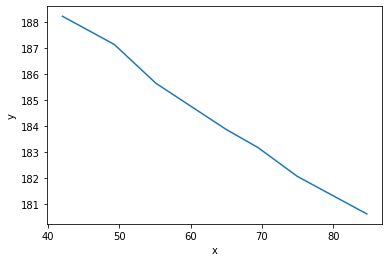

In [94]:
sns.lineplot(data=data_frames["TYPE_WAYPOINT"], x="x", y="y", sort=False)

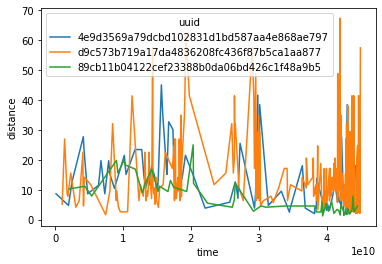

In [95]:
sns.lineplot(data=data_frames["TYPE_BEACON"], x="time", y="distance", hue="uuid");

<AxesSubplot:xlabel='time'>

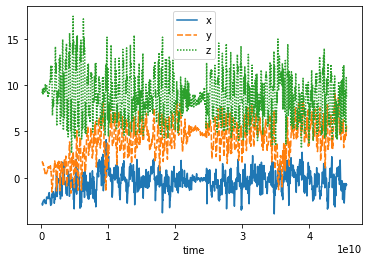

In [91]:
sns.lineplot(data=data_frames["TYPE_ACCELEROMETER"][["x", "y", "z"]])

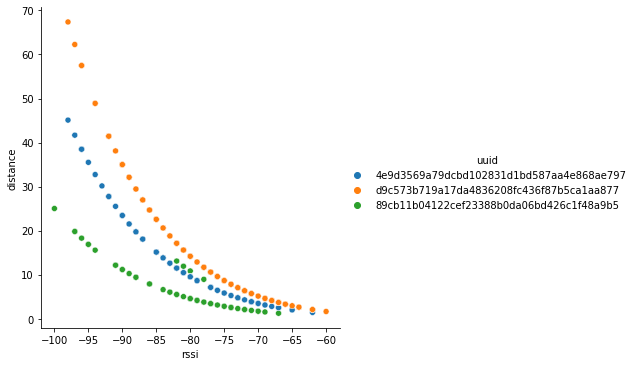

In [92]:
sns.relplot(data=data_frames["TYPE_BEACON"], x="rssi", y="distance", hue="uuid")

<AxesSubplot:xlabel='time'>

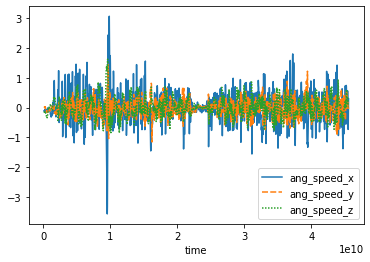

In [98]:
sns.lineplot(data=data_frames["TYPE_GYROSCOPE"][["ang_speed_x", "ang_speed_y", "ang_speed_z"]])

<AxesSubplot:xlabel='time'>

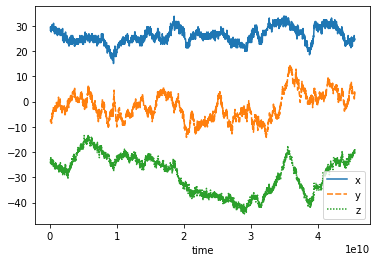

In [134]:
sns.lineplot(data=data_frames["TYPE_MAGNETIC_FIELD"][["x", "y", "z"]])

<AxesSubplot:xlabel='time', ylabel='rssi'>

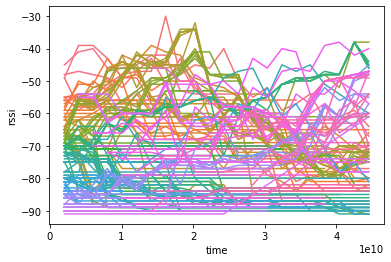

In [146]:
sns.lineplot(data=data_frames["TYPE_WIFI"], x="time", y="rssi", hue="bssid", legend=None)